In [1]:
spark

In [2]:
dir0 = '/home/cloudera/2.kkbox_churn/data01/big_table_01/'
infile = dir0 + 'all-features_has-expired_auto-renew-0'

df0 = spark.read.format('parquet').load(infile)

In [3]:
df0.printSchema()

root
 |-- msno: string (nullable = true)
 |-- city: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- registered_via: string (nullable = true)
 |-- days_since_init_regist: integer (nullable = true)
 |-- init_date: string (nullable = true)
 |-- final_date: string (nullable = true)
 |-- gaps_count: integer (nullable = true)
 |-- total_gap_len: integer (nullable = true)
 |-- has_long_gap: boolean (nullable = true)
 |-- has_expired: boolean (nullable = true)
 |-- last_pay_method: string (nullable = true)
 |-- last_plan_days: integer (nullable = true)
 |-- last_list_price: integer (nullable = true)
 |-- last_actual_paid: integer (nullable = true)
 |-- last_discount: integer (nullable = true)
 |-- last_paid_per_day: double (nullable = true)
 |-- actual_paid_cnt_uniq: integer (nullable = true)
 |-- actual_paid_mode: integer (nullable = true)
 |-- auto_renew_cnt_uniq: integer (nullable = true)
 |-- auto_renew_mode: boolean (nullable = true)

In [4]:
df0.count()

32733

In [5]:
df0.columns

['msno',
 'city',
 'age',
 'gender',
 'registered_via',
 'days_since_init_regist',
 'init_date',
 'final_date',
 'gaps_count',
 'total_gap_len',
 'has_long_gap',
 'has_expired',
 'last_pay_method',
 'last_plan_days',
 'last_list_price',
 'last_actual_paid',
 'last_discount',
 'last_paid_per_day',
 'actual_paid_cnt_uniq',
 'actual_paid_mode',
 'auto_renew_cnt_uniq',
 'auto_renew_mode',
 'discount_cnt_uniq',
 'discount_mode',
 'list_price_cnt_uniq',
 'list_price_mode',
 'pay_method_cnt_uniq',
 'pay_method_mode',
 'plan_days_cnt_uniq',
 'plan_days_mode',
 'actual_paid_sum',
 'actual_paid_per_sub_day',
 'discount_sum',
 'discount_per_sub_day',
 'list_price_sum',
 'list_price_per_sub_day',
 'last12WeekOnLine',
 'w12_M25',
 'w12_M50',
 'w12_M75',
 'w12_M985',
 'w12_M100',
 'w12_Munq',
 'w12_Msecs',
 'w12_Mtotal',
 'w12_M25_D_Mtotal',
 'w12_M50_D_Mtotal',
 'w12_M75_D_Mtotal',
 'w12_M985_D_Mtotal',
 'w12_M100_D_Mtotal',
 'w12_Munq_D_Mtotal',
 'w12_M25M50M75_D_Mtotal',
 'w12_M985M100_D_Mtotal',

In [5]:
df0.groupBy('is_churn').count().show()

+--------+-----+
|is_churn|count|
+--------+-----+
|    true|18031|
|   false|14702|
+--------+-----+



In [3]:
import re

group_members = ['city', 'age', 'gender', 'registered_via', 'days_since_init_regist']
group_trans = ['init_date', 'final_date', 'gaps_count', 'total_gap_len', 'has_long_gap',
               'has_expired', 'last_pay_method', 'last_plan_days', 'last_list_price', 'last_actual_paid',
               'last_discount', 'last_paid_per_day', 'actual_paid_cnt_uniq', 'actual_paid_mode',
               'auto_renew_cnt_uniq', 'auto_renew_mode', 'discount_cnt_uniq', 'discount_mode',
               'list_price_cnt_uniq', 'list_price_mode', 'pay_method_cnt_uniq', 'pay_method_mode',
               'plan_days_cnt_uniq', 'plan_days_mode', 'actual_paid_sum', 'actual_paid_per_sub_day',
               'discount_sum', 'discount_per_sub_day', 'list_price_sum', 'list_price_per_sub_day']
group_userlogs = [c  for c in df0.columns 
                  if re.match('last\d+WeekOnLine', c) or re.match('w\d+_', c)]

# [utility functions]

In [4]:
def plot_against_categorical(df, cat_field, ax, sort_as_int=False):
    df_ = df.crosstab(cat_field, 'is_churn') \
         .withColumnRenamed('false' ,'not chrun') \
         .withColumnRenamed('true' ,'chrun')
    if sort_as_int:
        df_ = df_.sort(col(cat_field+'_is_churn').cast('int'))
        
    tb = df_.toPandas().set_index(cat_field+'_is_churn')
    tb.plot.bar(ax=ax, alpha=0.7)

    ax.set(xlabel=cat_field, ylabel='members count')

In [42]:
def plot_scatter(df, field_x, field_y, ax, alpha=0.8, color='b'):
    tb = df.select(field_x, field_y).toPandas()
    tb.plot.scatter(ax=ax, x=field_x, y=field_y, alpha=alpha, c=color)

In [37]:
import matplotlib.pyplot as plt
import numpy as np
def plot_against_continuous(df, cont_field, bins, value_range):
    ''' Returns (fig, axes) '''
    arr_is_churn = np.array(df.where('is_churn').select(cont_field).collect())
    arr_not_churn = np.array(df.where(~col('is_churn')).select(cont_field).collect())

    fig, axes = plt.subplots(2, 1, sharex=True)
    axes[0].hist(arr_not_churn, bins, range=value_range)
    axes[1].hist(arr_is_churn, bins, range=value_range)

    axes[0].set(title='not churn', xlim=value_range, xlabel=cont_field, ylabel='members count')
    axes[1].set(title='churn', xlim=value_range, xlabel=cont_field, ylabel='members count')

    fig.subplots_adjust(hspace=0.5)
    return (fig, axes)

# member data

In [112]:
df1 = df0.select(['msno', 'is_churn'] + group_members)

In [114]:
df1.show(2)

+--------------------+--------+----+---+------+--------------+----------------------+
|                msno|is_churn|city|age|gender|registered_via|days_since_init_regist|
+--------------------+--------+----+---+------+--------------+----------------------+
|+2GgJdINpS53hcABf...|   false|   5| 41|female|             9|                  3749|
|+2gGE8RHPZ013pQs4...|    true|  18| 30|female|             9|                  2264|
+--------------------+--------+----+---+------+--------------+----------------------+
only showing top 2 rows



## days_since_init_regist

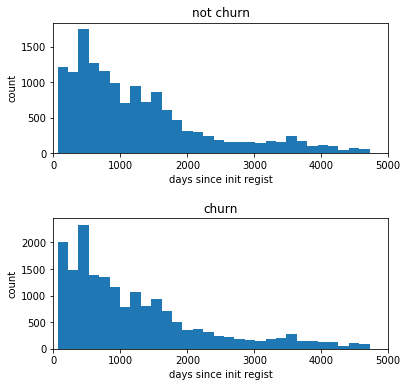

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

arr_dsir_is_churn = np.array(df1.where('is_churn').select('days_since_init_regist').collect())
arr_dsir_not_churn = np.array(df1.where(~col('is_churn')).select('days_since_init_regist').collect())

fig, axes = plt.subplots(2, 1)
axes[0].hist(arr_dsir_not_churn, 30)
axes[1].hist(arr_dsir_is_churn, 30)

axes[0].set(title='not churn', xlim=[0,5000], xlabel='days since init regist', ylabel='count')
axes[1].set(title='churn', xlim=[0,5000], xlabel='days since init regist', ylabel='count')

fig.set_size_inches(6, 6)
fig.subplots_adjust(hspace=0.5)
plt.show()

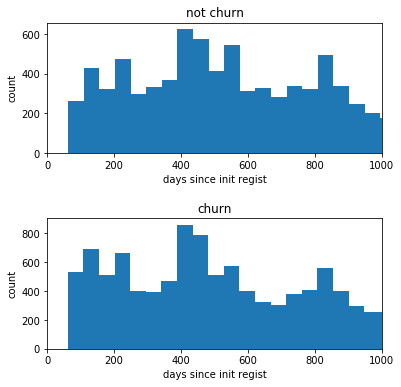

In [77]:
fig, axes = plt.subplots(2, 1)
axes[0].hist(arr_dsir_not_churn, 100)
axes[1].hist(arr_dsir_is_churn, 100)

axes[0].set(title='not churn', xlim=[0,1000], xlabel='days since init regist', ylabel='count')
axes[1].set(title='churn', xlim=[0,1000], xlabel='days since init regist', ylabel='count')

fig.set_size_inches(6, 6)
fig.subplots_adjust(hspace=0.5)
plt.show()

## registered_via

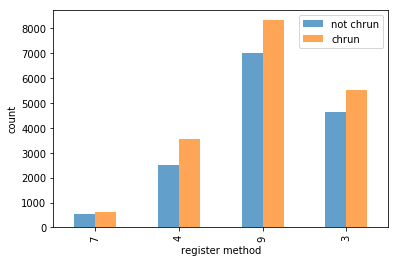

In [75]:
df = df1.crosstab('registered_via', 'is_churn') \
     .withColumnRenamed('false' ,'not chrun') \
     .withColumnRenamed('true' ,'chrun')
tb = df.toPandas().set_index('registered_via_is_churn')

fig, ax = plt.subplots()
tb.plot.bar(ax=ax, alpha=0.7)

ax.set(xlabel='register method', ylabel='count')

plt.show()

## city

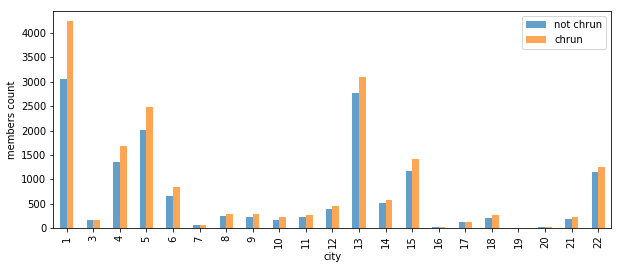

In [116]:
fig, ax = plt.subplots()
plot_against_categorical(df1, 'city', ax, sort_as_int=True)
fig.set_size_inches(10,4)
plt.show()

# transactions

In [117]:
df1 = df0.select(['msno', 'is_churn'] + group_trans)

In [88]:
print(df1.columns)

['msno', 'is_churn', 'init_date', 'final_date', 'gaps_count', 'total_gap_len', 'has_long_gap', 'has_expired', 'last_pay_method', 'last_plan_days', 'last_list_price', 'last_actual_paid', 'last_discount', 'last_paid_per_day', 'actual_paid_cnt_uniq', 'actual_paid_mode', 'auto_renew_cnt_uniq', 'auto_renew_mode', 'discount_cnt_uniq', 'discount_mode', 'list_price_cnt_uniq', 'list_price_mode', 'pay_method_cnt_uniq', 'pay_method_mode', 'plan_days_cnt_uniq', 'plan_days_mode', 'actual_paid_sum', 'actual_paid_per_sub_day', 'discount_sum', 'discount_per_sub_day', 'list_price_sum', 'list_price_per_sub_day']


## gaps

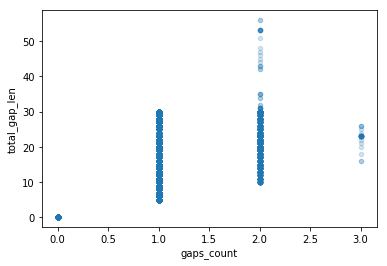

In [91]:
tb = df1.select('gaps_count', 'total_gap_len').toPandas()

fig, ax = plt.subplots()
tb.plot.scatter(ax=ax, x='gaps_count', y='total_gap_len', alpha=0.2)

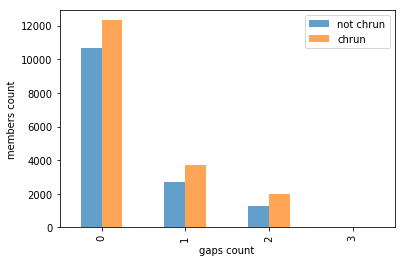

In [95]:
df = df1.crosstab('gaps_count', 'is_churn') \
     .withColumnRenamed('false' ,'not chrun').withColumnRenamed('true' ,'chrun') \
     .sort(col('gaps_count_is_churn'))
tb = df.toPandas().set_index('gaps_count_is_churn')

fig, ax = plt.subplots()
tb.plot.bar(ax=ax, alpha=0.7)

ax.set(xlabel='gaps count', ylabel='members count')

plt.show()

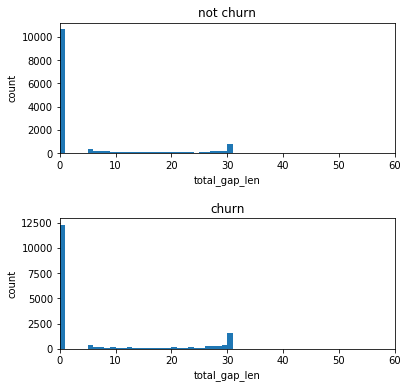

In [109]:
arr_is_churn = np.array(df1.where('is_churn').select('total_gap_len').collect())
arr_not_churn = np.array(df1.where(~col('is_churn')).select('total_gap_len').collect())

fig, axes = plt.subplots(2, 1)
axes[0].hist(arr_not_churn, 60, range=(0,60))
axes[1].hist(arr_is_churn, 60, range=(0,60))

axes[0].set(title='not churn', xlim=[0,60], xlabel='total_gap_len', ylabel='count')
axes[1].set(title='churn', xlim=[0,60], xlabel='total_gap_len', ylabel='count')

fig.set_size_inches(6, 6)
fig.subplots_adjust(hspace=0.5)
plt.show()

In [104]:
df1.crosstab('has_long_gap', 'is_churn').show()

+---------------------+-----+-----+
|has_long_gap_is_churn|false| true|
+---------------------+-----+-----+
|                false|14702|18031|
+---------------------+-----+-----+



## last_pay_method

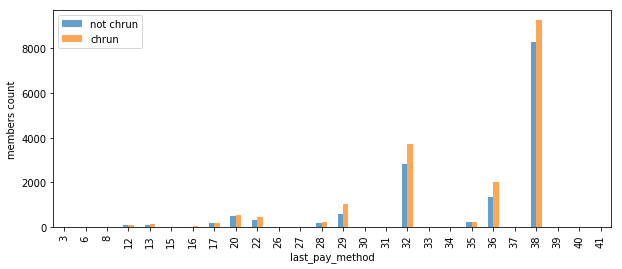

In [122]:
fig, ax = plt.subplots()
plot_against_categorical(df1, 'last_pay_method', ax, sort_as_int=True)
fig.set_size_inches(10,4)
plt.show()

## last_plan_days

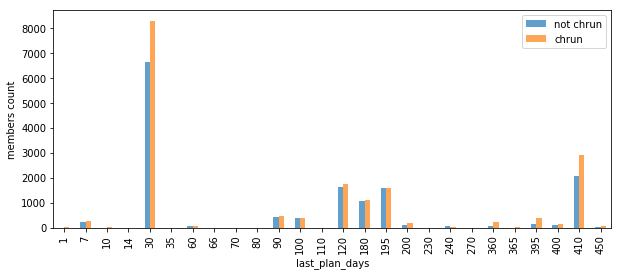

In [125]:
fig, ax = plt.subplots()
plot_against_categorical(df1, 'last_plan_days', ax, sort_as_int=True)
fig.set_size_inches(10,4)
plt.show()

## last_discount

In [134]:
df1.crosstab('last_discount', 'is_churn').show()

+----------------------+-----+-----+
|last_discount_is_churn|false| true|
+----------------------+-----+-----+
|                   149|   13|   11|
|                  -894|    0|    1|
|                     0|14689|18019|
+----------------------+-----+-----+



In [137]:
df1.select(max('last_paid_per_day')).show()

+----------------------+
|max(last_paid_per_day)|
+----------------------+
|                   6.0|
+----------------------+



## last_paid_per_day

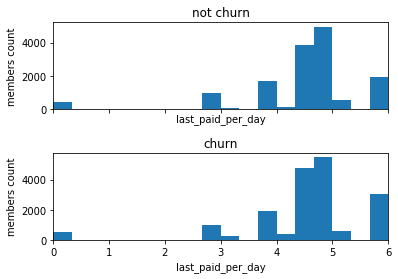

In [139]:
fig, axes = plot_against_continuous(df1, 'last_paid_per_day', 18, (0,6))
plt.show()

## discount_mode

In [140]:
df1.crosstab('discount_mode', 'is_churn').show()

+----------------------+-----+-----+
|discount_mode_is_churn|false| true|
+----------------------+-----+-----+
|                   149|    2|    8|
|                  -894|    0|    1|
|                     0|14700|18022|
+----------------------+-----+-----+



## list_price_cnt_uniq

In [142]:
df1.crosstab('list_price_cnt_uniq', 'is_churn').sort('list_price_cnt_uniq_is_churn').show()

+----------------------------+-----+-----+
|list_price_cnt_uniq_is_churn|false| true|
+----------------------------+-----+-----+
|                           1|13104|16095|
|                           2| 1536| 1852|
|                           3|   61|   83|
|                           4|    1|    1|
+----------------------------+-----+-----+



## pay_method_cnt_uniq

In [144]:
df1.crosstab('pay_method_cnt_uniq', 'is_churn').sort('pay_method_cnt_uniq_is_churn').show()

+----------------------------+-----+-----+
|pay_method_cnt_uniq_is_churn|false| true|
+----------------------------+-----+-----+
|                           1|13394|16363|
|                           2| 1258| 1593|
|                           3|   49|   75|
|                           4|    1|    0|
+----------------------------+-----+-----+



## pay_method_mode

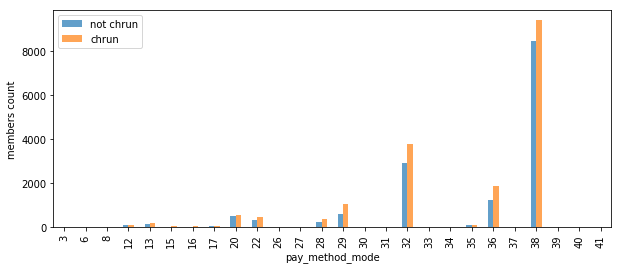

In [143]:
fig, ax = plt.subplots()
plot_against_categorical(df1, 'pay_method_mode', ax, sort_as_int=True)
fig.set_size_inches(10,4)
plt.show()

## actual_paid_sum

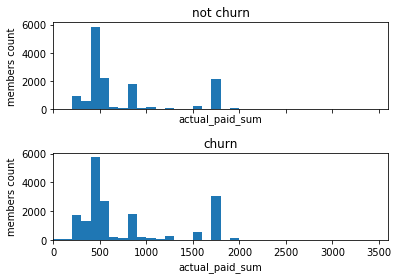

In [147]:
fig, axes = plot_against_continuous(df1, 'actual_paid_sum', 36, (0,3600))
plt.show()

## actual_paid_per_sub_day

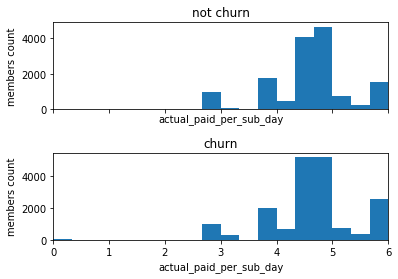

In [149]:
fig, axes = plot_against_continuous(df1, 'actual_paid_per_sub_day', 18, (0,6))
plt.show()

## discount_sum

In [152]:
df1.crosstab('discount_sum', 'is_churn').show()

+---------------------+-----+-----+
|discount_sum_is_churn|false| true|
+---------------------+-----+-----+
|                  149|   23|   21|
|                 -894|    0|    1|
|                    0|14679|18009|
+---------------------+-----+-----+



## list_price_sum

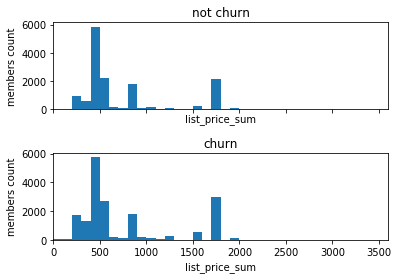

In [153]:
fig, axes = plot_against_continuous(df1, 'list_price_sum', 36, (0,3600))
plt.show()

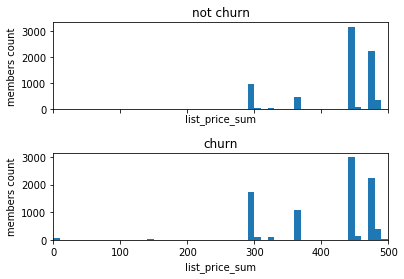

In [155]:
fig, axes = plot_against_continuous(df1, 'list_price_sum', 50, (0,500))
plt.show()

# user logs

In [7]:
from pyspark.sql.functions import col, when
df1 = df0.select(['msno', 'is_churn'] + group_userlogs) \
      .withColumn('w1_secs_per_song', (col('w1_Msecs')/col('w1_Mtotal')))

In [22]:
df1.printSchema()

root
 |-- msno: string (nullable = true)
 |-- is_churn: boolean (nullable = true)
 |-- last12WeekOnLine: integer (nullable = true)
 |-- w12_M25: integer (nullable = true)
 |-- w12_M50: integer (nullable = true)
 |-- w12_M75: integer (nullable = true)
 |-- w12_M985: integer (nullable = true)
 |-- w12_M100: integer (nullable = true)
 |-- w12_Munq: integer (nullable = true)
 |-- w12_Msecs: integer (nullable = true)
 |-- w12_Mtotal: integer (nullable = true)
 |-- w12_M25_D_Mtotal: double (nullable = true)
 |-- w12_M50_D_Mtotal: double (nullable = true)
 |-- w12_M75_D_Mtotal: double (nullable = true)
 |-- w12_M985_D_Mtotal: double (nullable = true)
 |-- w12_M100_D_Mtotal: double (nullable = true)
 |-- w12_Munq_D_Mtotal: double (nullable = true)
 |-- w12_M25M50M75_D_Mtotal: double (nullable = true)
 |-- w12_M985M100_D_Mtotal: double (nullable = true)
 |-- w12_M25M50_D_Mtotal: double (nullable = true)
 |-- w12_M25_D_M50M75M985M100: double (nullable = true)
 |-- w12_M25M50_D_M75M985M100: doubl

## last 1 week
### last1WeekOnLine, w1_Mtotle, w1_Msecs

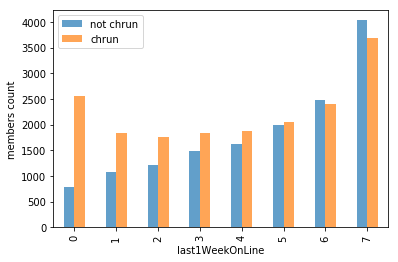

In [8]:
fig, ax = plt.subplots()
plot_against_categorical(df1, 'last1WeekOnLine', ax, sort_as_int=True)

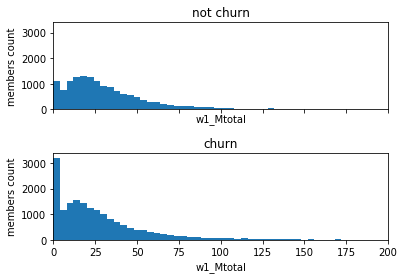

In [195]:
df2 = df1.where(col('w1_Mtotal').isNotNull())
fig, axes = plot_against_continuous(df2, 'w1_Mtotal', 50, (0,200))
for i in [0,1]:
    axes[i].set(ylim=(0,3400))
plt.show()

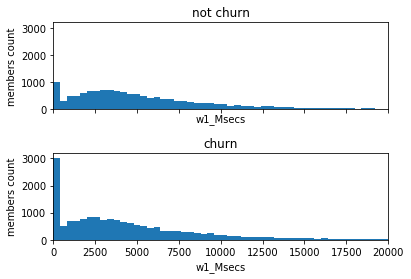

In [196]:
fig, axes = plot_against_continuous(df1, 'w1_Msecs', 50, (0,20000))
for i in [0,1]:
    axes[i].set(ylim=(0,3200))
plt.show()

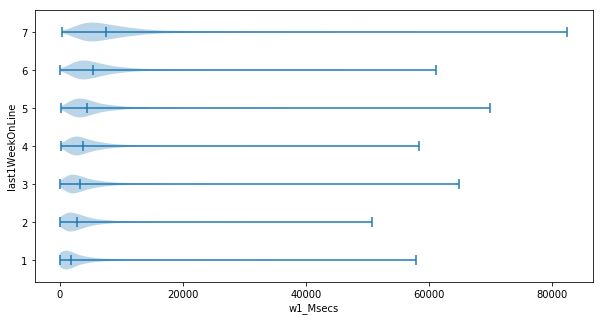

In [142]:
import matplotlib.pyplot as plt
import numpy as np

arrs = []
for ds in range(1,8):
    arr = np.array(df1.where(col('last1WeekOnLine') == ds).select('w1_Msecs').collect())
    arrs.append(arr)

#
fig, ax = plt.subplots()
ax.violinplot(arrs, [1,2,3,4,5,6,7], points=100, vert=False, showmedians=True)
ax.set(xlabel='w1_Msecs', ylabel='last1WeekOnLine')
fig.set_size_inches(10,5)
plt.show()

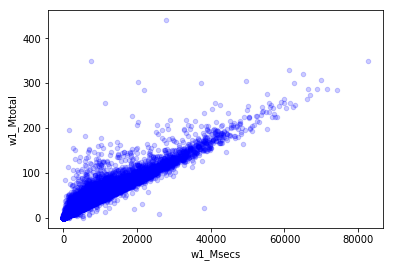

In [48]:
fig, ax = plt.subplots()
plot_scatter(df1, 'w1_Msecs', 'w1_Mtotal', ax, alpha=0.2, color='b')
plt.show()

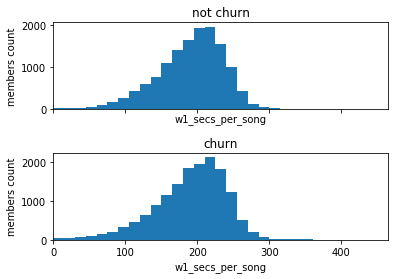

In [38]:
df2 = df1.where(col('w1_secs_per_song').isNotNull())
fig, axes = plot_against_continuous(df2, 'w1_secs_per_song', 31, (0,465))
plt.show()

### w1_Munq_D_Mtotal

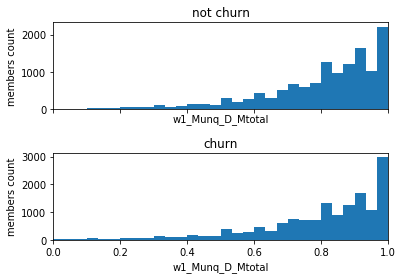

In [197]:
df2 = df1.where(col('last1WeekOnLine') > 0) \
         .where(col('w1_Mtotal') > 0)

fig, ax = plot_against_continuous(df2, 'w1_Munq_D_Mtotal', 30, (0, 1))
plt.show()

### w1_Mxx_D_Mtotal

In [168]:
df2 = df1.where(col('last1WeekOnLine') > 0) \
         .where(col('w1_Mtotal') > 0)

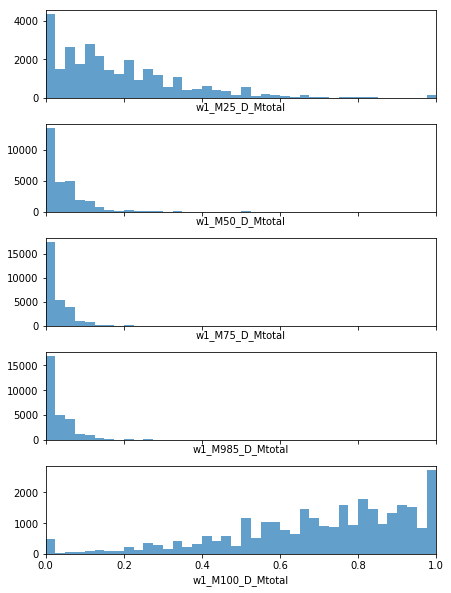

In [187]:
import matplotlib.pyplot as plt
import numpy as np

pts = ['25', '50', '75', '985', '100']
arrs = []
for pt in pts:
    arr = np.array(df2.select('w1_M'+pt+'_D_Mtotal').collect())
    arrs.append(arr)

#
fig, axes = plt.subplots(5,1, sharex=True)
for i in range(5):
    #axes[i].violinplot(arrs[i], [0], points=100, vert=False, showmedians=True)
    axes[i].hist(arrs[i], 40, range=(0,1), alpha=0.7)
    axes[i].set(xlabel='w1_M'+pts[i]+'_D_Mtotal')
    
axes[0].set(xlim=(0,1))    
fig.set_size_inches(7,10)
fig.subplots_adjust(hspace=0.3)
plt.show()

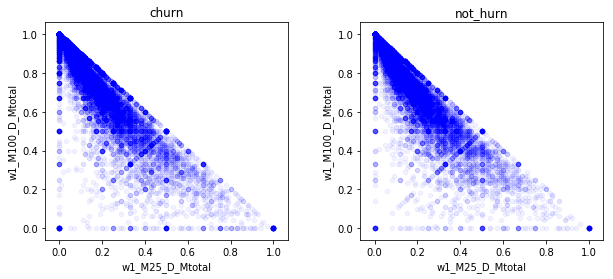

In [181]:
df2_is_churn = df2.where(col('is_churn'))
df2_not_churn = df2.where(~col('is_churn'))

fig, axes = plt.subplots(1,2)

plot_scatter(df2_is_churn, 'w1_M25_D_Mtotal', 'w1_M100_D_Mtotal', axes[0], alpha=0.05, color='b')
axes[0].set(title='churn')

plot_scatter(df2_not_churn, 'w1_M25_D_Mtotal', 'w1_M100_D_Mtotal', axes[1], alpha=0.05, color='b')
axes[1].set(title='not_hurn')

fig.set_size_inches(10,4)
fig.subplots_adjust(wspace=0.3)
plt.show()

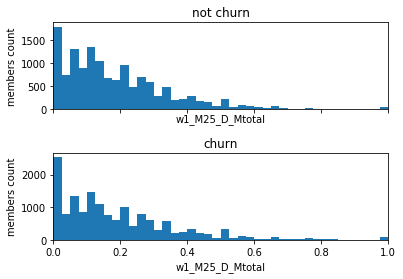

In [100]:
df2 = df1.where(col('last1WeekOnLine') > 0).where(col('w1_M25_D_Mtotal').isNotNull())
fig, ax = plot_against_continuous(df2, 'w1_M25_D_Mtotal', 40, (0, 1))
plt.show()

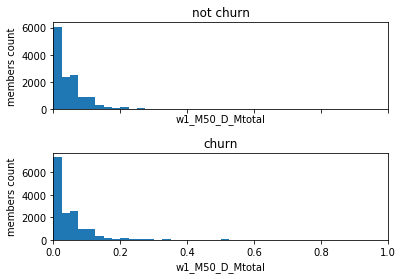

In [107]:
df2 = df1.where(col('last1WeekOnLine') > 0).where(col('w1_M50_D_Mtotal').isNotNull())
fig, ax = plot_against_continuous(df2, 'w1_M50_D_Mtotal', 40, (0, 1))
plt.show()

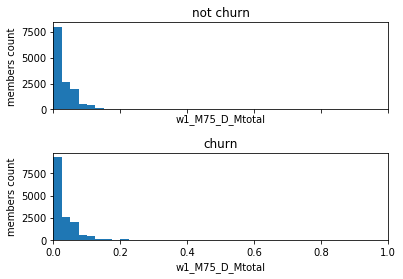

In [108]:
df2 = df1.where(col('last1WeekOnLine') > 0).where(col('w1_M75_D_Mtotal').isNotNull())
fig, ax = plot_against_continuous(df2, 'w1_M75_D_Mtotal', 40, (0, 1))
plt.show()

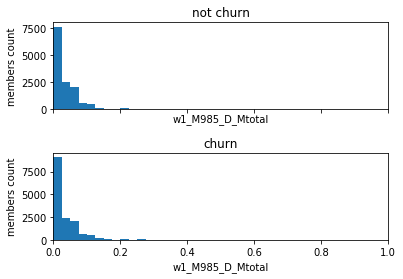

In [109]:
df2 = df1.where(col('last1WeekOnLine') > 0).where(col('w1_M985_D_Mtotal').isNotNull())
fig, ax = plot_against_continuous(df2, 'w1_M985_D_Mtotal', 40, (0, 1))
plt.show()

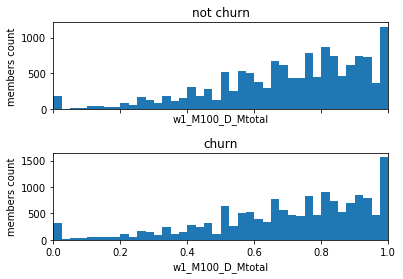

In [110]:
df2 = df1.where(col('last1WeekOnLine') > 0).where(col('w1_M100_D_Mtotal').isNotNull())
fig, ax = plot_against_continuous(df2, 'w1_M100_D_Mtotal', 40, (0, 1))
plt.show()

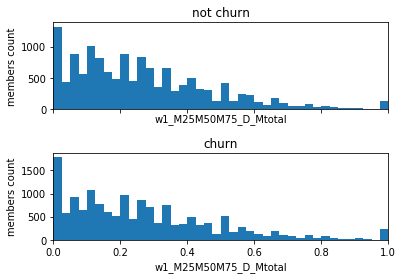

In [101]:
df2 = df1.where(col('last1WeekOnLine') > 0).where(col('w1_M25M50M75_D_Mtotal').isNotNull())
fig, ax = plot_against_continuous(df2, 'w1_M25M50M75_D_Mtotal', 40, (0, 1))
plt.show()

In [93]:
print([c for c in df1.columns if c=='last1WeekOnLine' or c.startswith('w1_')])

['last1WeekOnLine', 'w1_M25', 'w1_M50', 'w1_M75', 'w1_M985', 'w1_M100', 'w1_Munq', 'w1_Msecs', 'w1_Mtotal', 'w1_M25_D_Mtotal', 'w1_M50_D_Mtotal', 'w1_M75_D_Mtotal', 'w1_M985_D_Mtotal', 'w1_M100_D_Mtotal', 'w1_Munq_D_Mtotal', 'w1_M25M50M75_D_Mtotal', 'w1_M985M100_D_Mtotal', 'w1_M25M50_D_Mtotal', 'w1_M25_D_M50M75M985M100', 'w1_M25M50_D_M75M985M100', 'w1_M25M50M75_D_M985M100', 'w1_M25M50M75M985_D_M100', 'w1_secs_per_song']


## last 4 weeks

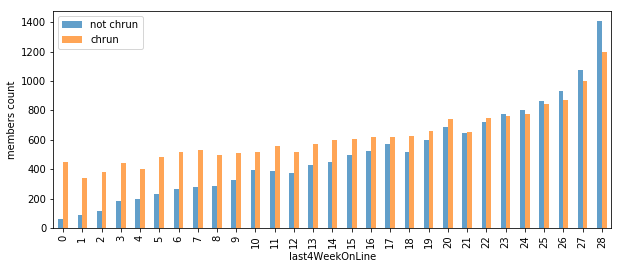

In [200]:
fig, ax = plt.subplots()
plot_against_categorical(df1, 'last4WeekOnLine', ax, sort_as_int=True)
fig.set_size_inches(10, 4)
plt.show()

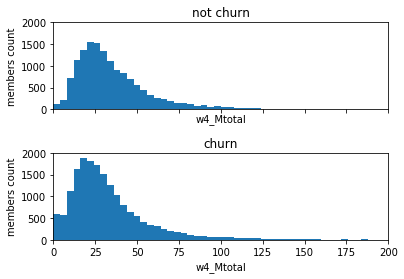

In [202]:
df2 = df1.where(col('w4_Mtotal').isNotNull())
fig, axes = plot_against_continuous(df2, 'w4_Mtotal', 50, (0,200))
for i in [0,1]:
    axes[i].set(ylim=(0,2000))
plt.show()

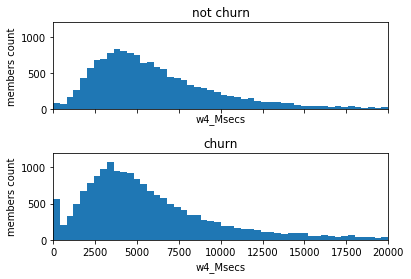

In [206]:
fig, axes = plot_against_continuous(df1, 'w4_Msecs', 50, (0,20000))
for i in [0,1]:
    axes[i].set(ylim=(0,1200))
plt.show()

In [207]:
df2 = df1.where(col('last4WeekOnLine') > 0) \
         .where(col('w4_Mtotal') > 0)

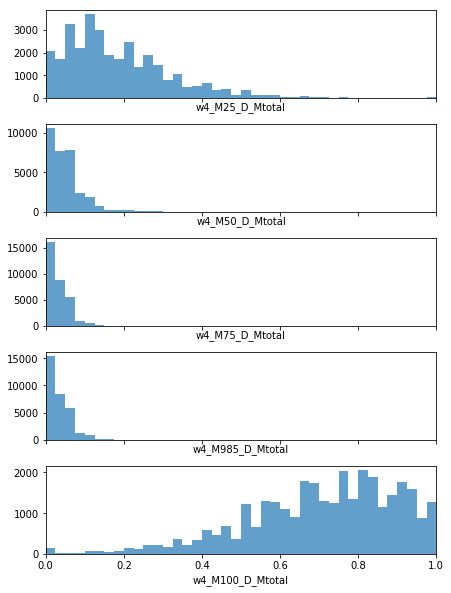

In [208]:
import matplotlib.pyplot as plt
import numpy as np

pts = ['25', '50', '75', '985', '100']
arrs = []
for pt in pts:
    arr = np.array(df2.select('w4_M'+pt+'_D_Mtotal').collect())
    arrs.append(arr)

#
fig, axes = plt.subplots(5,1, sharex=True)
for i in range(5):
    axes[i].hist(arrs[i], 40, range=(0,1), alpha=0.7)
    axes[i].set(xlabel='w4_M'+pts[i]+'_D_Mtotal')
    
axes[0].set(xlim=(0,1))    
fig.set_size_inches(7,10)
fig.subplots_adjust(hspace=0.3)
plt.show()

## last 1 week vs. last 4 weeks

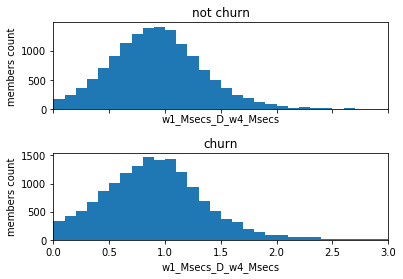

In [212]:
df2 = df1.where(col('w1_Msecs') > 0).where(col('w4_Msecs') > 0) \
      .select((col('w1_Msecs')/col('w4_Msecs')).alias('w1_Msecs_D_w4_Msecs'),
              'is_churn')

fig, axes = plot_against_continuous(df2, 'w1_Msecs_D_w4_Msecs', 30, (0,3))
plt.show()

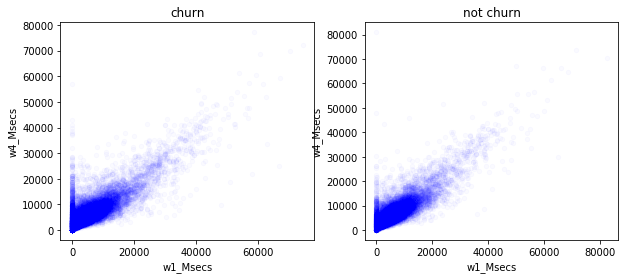

In [230]:
df1_is_churn = df1.where(col('is_churn'))
df1_not_churn = df1.where(~col('is_churn'))

fig, axes = plt.subplots(1,2)
plot_scatter(df1_is_churn, 'w1_Msecs', 'w4_Msecs', axes[0], alpha=0.02, color='b')
axes[0].set(title='churn')
plot_scatter(df1_not_churn, 'w1_Msecs', 'w4_Msecs', axes[1], alpha=0.02, color='b')
axes[1].set(title='not churn')

fig.set_size_inches(10,4)
plt.show()

## last 1 week vs. last 12 weeks

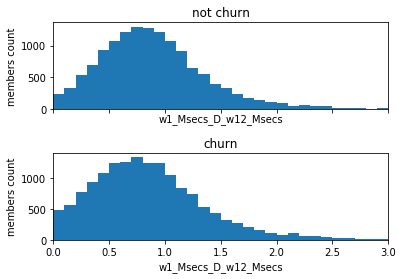

In [222]:
df2 = df1.where(col('w1_Msecs') > 0).where(col('w12_Msecs') > 0) \
      .select((col('w1_Msecs')/col('w12_Msecs')).alias('w1_Msecs_D_w12_Msecs'),
              'is_churn')

fig, axes = plot_against_continuous(df2, 'w1_Msecs_D_w12_Msecs', 30, (0,3))
plt.show()

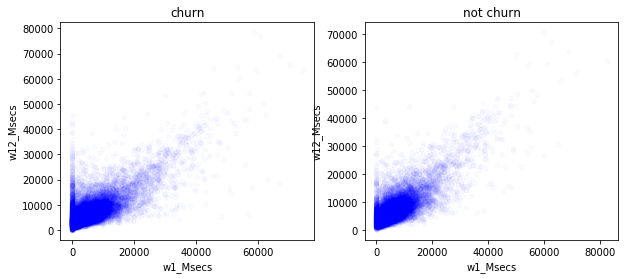

In [229]:
df1_is_churn = df1.where(col('is_churn'))
df1_not_churn = df1.where(~col('is_churn'))

fig, axes = plt.subplots(1,2)
plot_scatter(df1_is_churn, 'w1_Msecs', 'w12_Msecs', axes[0], alpha=0.02, color='b')
axes[0].set(title='churn')
plot_scatter(df1_not_churn, 'w1_Msecs', 'w12_Msecs', axes[1], alpha=0.02, color='b')
axes[1].set(title='not churn')

fig.set_size_inches(10,4)
plt.show()